# Intercomparison of AVHRR fire data vs other fire records

This script generates Extended Data Figures 1 & 2.

Intercomparison of AVHRR annual fire count data vs.:

* USA NIFC fire terrestrial records
* Canada NFDB terrestrial records 
* European terrestrial EFFIS
* MODIS Active fires (nighttime, and daytime)

In [1]:
import sys
import os

import csv
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from netCDF4 import Dataset
import datetime as dt
from scipy import stats
from pathlib import Path

#custom
sys.path.append('./../../lib')
import paths as paths
import utils as utils

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

define a plotting function

In [2]:
def panel_scatter_plot(d, xvar, yvar, panelvar, xlab, ylab, nrow, ncol, dim = None, 
                       labelcol=None):
    """ 
    
    simple multipanel plotter 
    
    
    
    usage e.g.:
    
    panel_scatter_plot(d=terrestrial_sub2, 
                   xvar='val_count_1st', yvar='count_1st', panelvar='NAME_0', 
                   xlab='Terrestrial database annual fire count (1st differences)', 
                   ylab='AVHRR annual fire count (1st differences)', 
                   nrow=4, ncol=2)
    """
    
    if dim:
        pass
    else:
        dim=(8,12)
        
    fig, axes = plt.subplots(figsize=dim, nrows=nrow, ncols=ncol, 
                             squeeze=False, sharex=False, sharey=False, 
                             gridspec_kw=dict(hspace=0.4, wspace=0.5))
    axes = axes.flatten()
    
    statstable = pd.DataFrame({'region': [],                               
                               'tau':[],'p':[],'intercept': [],
                               'slope':[],'lower':[],'upper':[],
                              })

    #mpl.rcParams.update({'font.size': 10})
    for i, name in enumerate(np.unique(d[panelvar])):
        ax = axes[i]
        df = d[d[panelvar] == name]
        y = df[yvar].values
        x = df[xvar].values

        # calculate stats and collate
        #lr_m, lr_c, lr_r, lr_p, lr_se = stats.linregress(x=x, y=y)
        tau, tau_p = stats.kendalltau(x=x, y=y)
        ts_m, ts_c, ts_lower, ts_upper = stats.theilslopes(x=x, y=y, alpha=0.95)        
        #print(name,tau_p)
        
        statstable.loc[len(statstable)] = [name,
                         round(tau,5), round(tau_p,5), round(ts_c,5), 
                         round(ts_m,5), round(ts_lower,5), round(ts_upper,5)]
        
        if tau_p < 0.1:
            ax.plot(x, y, marker='o', ms=5, linestyle='none', color='#ec7014', alpha=0.7)
            ax.plot(x, x * ts_m + ts_c,'#cc4c02', linewidth=2, linestyle='-')
            
            # with eq
            #lab = ('{0}\n'
            #       r'$\tau$={1:.2f}, p={2:.3f}'
            #       '\ny={3:.3f}x{4:+.2f}\nn={5}').format(name, tau, tau_p, ts_m, ts_c, df.shape[0])            
            
            # no eq
            if tau_p < 0.001:
                lab = (r'$\tau$={0:.2f}, p<0.001'
                       '\nn={1}').format(tau, df.shape[0]) 
            else:
                lab = (r'$\tau$={0:.2f}, p={1:.3f}'
                       '\nn={2}').format(tau, tau_p, df.shape[0])            

            ax.text(0.02, 0.95, lab, 
                    horizontalalignment='left',
                    verticalalignment='top', 
                    transform=ax.transAxes,
                    fontsize=8)
        else:
            ax.plot(x, y, marker='o', ms=5, linestyle='none', color='#969696', alpha=0.7)
            lab = 'p={0:.3f} \nn={1}'.format(tau_p, df.shape[0])
            ax.text(0.02, 0.95, lab, 
                    horizontalalignment='left',
                    verticalalignment='top', 
                    transform=ax.transAxes,
                    fontsize=8)          
        # make plots square
        ratio = 1.0
        xleft, xright = ax.get_xlim()
        ybottom, ytop = ax.get_ylim()
        ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
        
        # tick label size
        ax.tick_params(axis='both', which='both', labelsize=8)
        if labelcol:
            ax.set_title(df[labelcol].values[0], fontsize=9)
        else:
            ax.set_title(name, fontsize=9)

    # broad axis labels on dummy ax
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel(xlab,fontsize=10, labelpad=15)
    plt.ylabel(ylab,fontsize=10, labelpad=15)   
    
    return fig, axes, statstable

define some helper functions

In [3]:
def grouped_first_diff(df, sortCol, diffCol, outCol, sortAsc=True):
    """ pandas .apply() function
    sort on sortCol, then calc first diff using diffCol"""
    df = df.sort_values(sortCol, ascending=sortAsc)
    df[outCol] = df[diffCol] - df[diffCol].shift(1)
    return df

def grouped_norm_trends(df, sortCol, normCol, outCol, sortAsc=True):
    df = df.sort_values(sortCol, ascending=sortAsc)
    val1 = df[normCol].values[0]
    df[outCol] = df[normCol] / val1
    return df

def grouped_add_rank(d):
    """create a single column index based on existing sorted order within group"""
    d.reset_index(inplace=True, drop=True)
    d.reset_index(inplace=True, drop=False)
    d.rename(columns={'index': 'rank'}, inplace=True)
    return(d)

setup file paths

In [4]:
dir_base = Path(paths.dir_main)

dir_out_figures = dir_base / "outputs"

# paths to AVHRR data aggregated annually by both GFED regions and countries
fn_av_gfed = dir_base / "GFED_annual_counts_calendaryr.csv"
fn_av_countries = dir_base / "NE_50m_ADM0_country_annual_fire_count_totals.csv"

#paths to terrestrial data files
fn_usa = dir_base / "aux_data/US_NIFC_data/US_FIFC_data3.csv"
fn_effis_ba = dir_base / "aux_data/effis/burnt_area_SSA8Odn.csv"
fn_effis_count = dir_base / "aux_data/effis/Number_of_fires_XR3J6B6.csv"
fn_canada = dir_base / "aux_data/canada_nfdb/NFDB_point_20171106_large_fires.csv"

# paths to MODIS Aqua files
fn_modis_aqua_am = dir_base / "aux_data/modis/MODIS_aqua_hotspots_masked_am.csv.gz"
fn_modis_aqua_pm = dir_base / "aux_data/modis/MODIS_aqua_hotspots_masked_pm.csv.gz"

# conversion factor mm -> inches. used for figure sizing.
mm = 1/25.4

# 1) preprocess inputs for terrestrial intercomparison
* how does AVHRR data compare to data from terrestrial country level fire records?

### AVHRR country level data

In [5]:
# load AVHRR annual count data from country level (Admin level 0) file
av_countries = pd.read_csv(str(fn_av_countries))
av_countries.rename(columns = {'ADM0_A3':'GID_0', 'ADMIN':'NAME_0'}, inplace = True)

# extract avhrr data for USA and Canada
av_usa = av_countries[av_countries['GID_0']=='USA']
av_can = av_countries[av_countries['GID_0']=='CAN']

### Preprocess data for USA
* Load the NIFC dataset and convert Acres -> Ha
* Merge with AVHRR data for USA
* Calculate first differences (https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775)

In [6]:
# load and filter
usa = pd.read_csv(str(fn_usa))
usa = usa[['Year', 'Fires', 'Acres']]

# convert to ha
usa['Acres'] = np.round(usa['Acres'] * 0.404686, 0).astype(int)

# format columns
usa.rename(columns = {'Year':'year', 'Acres':'val_ba', 'Fires':'val_count'}, inplace = True)

# combine NIFC data with avhrr data
usa = usa.merge(av_usa, left_on='year', right_on='year')[['GID_0', 'NAME_0', 'year','val_count', 'val_ba', 'count']]
usa.sort_values(['year'], inplace=True)

# calc first differences by subtracting the prior observation i.e. y'(t) = y(t) - y(t-1)
usa['val_ba_1st'] = usa['val_ba'] - usa['val_ba'].shift(1)
usa['val_count_1st'] = usa['val_count'] - usa['val_count'].shift(1)
usa['count_1st'] = usa['count'] - usa['count'].shift(1)
usa.head()

,GID_0,NAME_0,year,val_count,val_ba,count,val_ba_1st,val_count_1st,count_1st
22,USA,United States of America,1986,85907,1100407,611.0,NaN,NaN,NaN
21,USA,United States of America,1989,48949,739487,785.0,-360920.0,-36958.0,174.0
20,USA,United States of America,1990,66481,1870305,478.0,1130818.0,17532.0,-307.0
19,USA,United States of America,1991,75754,1195272,484.0,-675033.0,9273.0,6.0
18,USA,United States of America,1996,96363,2454824,797.0,1259552.0,20609.0,313.0


### load Canada NFDB 'large fires'
* apply some filters
* aggregate annually to count and calculate total BA
* merge with AVHRR for Canada
* calculate first differences as above

In [7]:
can_raw = pd.read_csv(str(fn_canada))

# filter
can_raw = can_raw[can_raw.LATITUDE > 40]
can_raw = can_raw[can_raw.LATITUDE <= 60]
can_raw = can_raw[can_raw.YEAR_ > 1985]

# generate annual count and BA
can = can_raw[['YEAR_', 'SIZE_HA']]\
    .groupby(['YEAR_'])\
    .agg(['count', 'sum'])\
    .reset_index()\
    .sort_values('YEAR_', ascending=True).droplevel(0, axis=1)
can.rename(columns = {'':'year', 'count':'val_count', 'sum':'val_ba'}, inplace = True)

# combine with AVHRR
can = can.merge(av_can, how='inner', on='year')

# calc first differences by subtracting the prior obs
can['val_ba_1st'] = can['val_ba'] - can['val_ba'].shift(1)
can['val_count_1st'] = can['val_count'] - can['val_count'].shift(1)
can['count_1st'] = can['count'] - can['count'].shift(1)
can.head()

,year,val_count,val_ba,GID_0,NAME_0,sat,sat_yr,count,val_ba_1st,val_count_1st,count_1st
0,1986,129,668145.30,CAN,Canada,NF,NF1986,232.0,NaN,NaN,NaN
1,1989,596,6731375.24,CAN,Canada,NH,NH1989,2653.0,6063229.94,467.0,2421.0
2,1990,221,619109.10,CAN,Canada,NH,NH1990,366.0,-6112266.14,-375.0,-2287.0
3,1991,248,1236604.24,CAN,Canada,NH,NH1991,658.0,617495.14,27.0,292.0
4,1996,369,1443890.10,CAN,Canada,NJ,NJ1996,436.0,207285.86,121.0,-222.0


### European countries from EFFIS 
* load the BA and number (count) of fires datasets from EFFIS
* do some preprocessing
* merge with AVHRR
* Calculate first differences 

In [8]:
# load
effis_ba = pd.read_csv(str(fn_effis_ba))
effis_count = pd.read_csv(str(fn_effis_count))

# rename cols for inconsistent countries
effis_ba.rename(columns = {'Czech Rep.':'Czech Republic', 'FYROM':'Macedonia'}, inplace = True)
effis_count.rename(columns = {'Czech Rep.':'Czech Republic', 'FYROM':'Macedonia'}, inplace = True)

#convert data from wide -> long format
effis_ba_long = pd.melt(effis_ba, id_vars=['year'])
effis_ba_long.rename(columns = {'variable':'NAME_0', 'value':'val_ba'}, inplace = True)
effis_ba_long.head()

effis_count_long = pd.melt(effis_count, id_vars=['year'])
effis_count_long.rename(columns = {'variable':'NAME_0', 'value':'val_count'}, inplace = True)
effis_count_long.head()

# merge the EFFIS data with AVHRR data, retaining only matching countries.
euro = av_countries.merge(right=effis_ba_long, how='inner', on=['NAME_0', 'year'])
euro = euro.merge(right=effis_count_long, how='inner', on=['NAME_0', 'year'])
#euro = euro.sort_values(['count'])

# get rid of NAs
euro.dropna(inplace=True)

# apply function that calculates first differences on a pandas 'groupby' based on country
euro = euro.groupby(['NAME_0','GID_0'])\
    .apply(grouped_first_diff, sortCol='year', diffCol='count', outCol='count_1st').reset_index(drop=True)
euro = euro.groupby(['NAME_0','GID_0'])\
    .apply(grouped_first_diff, sortCol='year', diffCol='val_ba', outCol='val_ba_1st').reset_index(drop=True)
euro = euro.groupby(['NAME_0','GID_0'])\
    .apply(grouped_first_diff, sortCol='year', diffCol='val_count', outCol='val_count_1st').reset_index(drop=True)

euro.head(5)

C:\Users\mdejong\AppData\Local\Temp\ipykernel_30360\4079593496.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  euro = euro.groupby(['NAME_0','GID_0'])\
C:\Users\mdejong\AppData\Local\Temp\ipykernel_30360\4079593496.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  euro = euro.groupby(['NAME_0','GID_0'])\
C:\Users\mdejong\AppData\Local\Temp\ipykernel_30360\4079593496.py:31: DeprecationWarning: DataFr

,GID_0,NAME_0,sat,sat_yr,year,count,val_ba,val_count,count_1st,val_ba_1st,val_count_1st
0,DZA,Algeria,NN,NN2011,2011,10.0,13593.0,2487.0,NaN,NaN,NaN
1,DZA,Algeria,NN,NN2012,2012,87.0,99061.0,5110.0,77.0,85468.0,2623.0
2,DZA,Algeria,NP,NP2013,2013,7.0,13396.0,2443.0,-80.0,-85665.0,-2667.0
3,DZA,Algeria,NP,NP2014,2014,18.0,43125.0,4629.0,11.0,29729.0,2186.0
4,DZA,Algeria,NP,NP2015,2015,5.0,13010.0,2383.0,-13.0,-30115.0,-2246.0


In [9]:
# combine
terrestrial = pd.concat([usa[['GID_0', 'NAME_0', 'year', 'count', 'val_ba', 'val_count', 'count_1st', 'val_ba_1st', 'val_count_1st']], 
                        can[['GID_0', 'NAME_0', 'year', 'count', 'val_ba', 'val_count', 'count_1st', 'val_ba_1st', 'val_count_1st']], 
                        euro[['GID_0', 'NAME_0', 'year', 'count', 'val_ba', 'val_count', 'count_1st', 'val_ba_1st', 'val_count_1st']]
                        ])

# remove rows with NAs
terrestrial = terrestrial.dropna()
terrestrial.head(5)

,GID_0,NAME_0,year,count,val_ba,val_count,count_1st,val_ba_1st,val_count_1st
21,USA,United States of America,1989,785.0,739487.0,48949.0,174.0,-360920.0,-36958.0
20,USA,United States of America,1990,478.0,1870305.0,66481.0,-307.0,1130818.0,17532.0
19,USA,United States of America,1991,484.0,1195272.0,75754.0,6.0,-675033.0,9273.0
18,USA,United States of America,1996,797.0,2454824.0,96363.0,313.0,1259552.0,20609.0
17,USA,United States of America,1997,426.0,1156171.0,66196.0,-371.0,-1298653.0,-30167.0


### subset and plot the AVHRR vs terrestrial data
* supplemental figure 1a
* keep only the regions with records for all years in the AVHRR dataset AND have mean BA > 50,000 Ha per year.

In [10]:
# subset
terrestrial = terrestrial.loc[terrestrial.NAME_0.isin(['Canada','United States of America',
                                                       'Spain','Portugal','Italy'])]
# scale data for legible axes
terrestrial.val_ba = terrestrial.val_ba / 1000
terrestrial.val_ba_1st = terrestrial.val_ba_1st / 1000

C:\Users\mdejong\AppData\Local\Temp\ipykernel_30360\3298660846.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


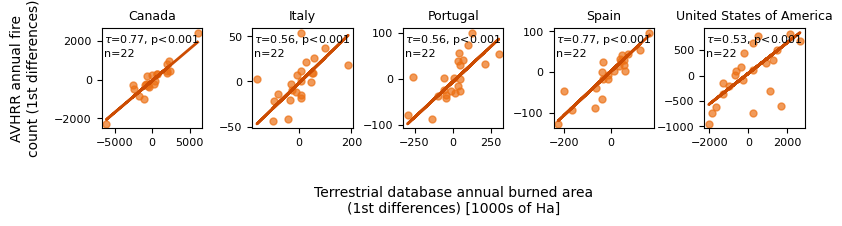

In [11]:
fig, axes, summary = panel_scatter_plot(d=terrestrial, 
                                        xvar='val_ba_1st', 
                                        yvar='count_1st', panelvar='NAME_0', 
                                        xlab='Terrestrial database annual burned area\n(1st differences) [1000s of Ha]', 
                                        ylab='AVHRR annual fire\ncount (1st differences)', 
                                        nrow=1, ncol=5, dim=(210*mm,60*mm)) 

fig.tight_layout()
fig.savefig(str(dir_out_figures / 's01a_terrestrial_intercomparison.png'), dpi=800)
fig.savefig(str(dir_out_figures / 's01a_terrestrial_intercomparison.pdf'))
summary.to_csv(str(dir_out_figures / 's01a_terrestrial_intercomparison.csv'), index=False)

# 2) Intercomparison with MODIS AQUA AM (Nighttime)

modis counts generated using 01c_mask_modis_v01.ipynb

* supplemental figure 1b
* Aqua AM overpass is the most similar observation time to AVHRR, so the most direct comparison for evaluation

In [12]:
#load AVHRR annual count data by GFED regions
av_gfed = pd.read_csv(str(fn_av_gfed))
print(av_gfed.shape)

av_gfed.rename(columns = {'gfed':'region', 'gfed_name':'region_name'}, inplace = True)
av_gfed = av_gfed.loc[av_gfed.region_name != 'Mask']\
          .sort_values(['region','year'], ascending=True)

#fix Typo
av_gfed.loc[av_gfed.region_name=='SEAS','region_name'] = 'SOAS'

av_gfed.head()

(368, 6)


,sat_yr,sat,year,region,region_name,count
1,NF1986,NF,1986,1,BONA,237
16,NH1989,NH,1989,1,BONA,2644
31,NH1990,NH,1990,1,BONA,358
46,NH1991,NH,1991,1,BONA,647
61,NJ1996,NJ,1996,1,BONA,442


load the MODIS Aqua AM data

In [13]:
modis_raw = pd.read_csv(str(fn_modis_aqua_am))
modis_raw.rename(columns = {'gfed':'region', 'gfed_name':'region_name'}, inplace = True)
modis_raw.head()

,lat,lon180,lon360,dt_utc,dt_lst,hours_lst,date_lst,month,year,doy,region,region_name
0,8.1449,20.1377,20.1377,2003-01-01 00:26:00,2003-01-01 01:43:52.291951,1.0,2003-01-01,1,2003,1,8,NHAF
1,8.1174,20.0504,20.0504,2003-01-19 00:14:00,2003-01-19 01:24:22.879528,1.0,2003-01-19,1,2003,19,8,NHAF
2,8.1161,20.0594,20.0594,2003-01-19 00:14:00,2003-01-19 01:24:25.039528,1.0,2003-01-19,1,2003,19,8,NHAF
3,7.3885,26.2658,26.2658,2003-01-01 00:26:00,2003-01-01 02:08:23.035951,2.0,2003-01-01,1,2003,1,8,NHAF
4,7.3841,26.2686,26.2686,2003-01-01 00:26:00,2003-01-01 02:08:23.707951,2.0,2003-01-01,1,2003,1,8,NHAF


In [14]:
# aggregate to years
modis2 = modis_raw[['region', 'region_name', 'year', 'doy']]\
    .groupby(['region', 'region_name', 'year'])\
    .agg(['count'])\
    .reset_index()\
    .sort_values('year', ascending=True).droplevel(0, axis=1)
# trim
modis2.columns = ['region', 'region_name', 'year', 'val_count']

### Merge MODIS and AVHRR data and do first differences

In [15]:
# combine regional data
modis2 = modis2.merge(av_gfed, how='inner', on=['region','region_name', 'year'])

## calculate global totals and 
modis_global = modis2[['year','val_count','count']]\
    .groupby(['year'])[['val_count','count']].sum().reset_index()\
    .sort_values('year', ascending=True)
modis_global['region'] = 99
modis_global['region_name'] = 'global'
modis_global['sat_yr'] = 'dummy'
modis_global['sat'] = 'dummy'

# add global to the main df
modis2 = pd.concat([modis2, modis_global])

# calculate first differences for both AVHRR and MODIS
modis2 = modis2.groupby(['region','region_name'])\
    .apply(grouped_first_diff, sortCol='year', diffCol='count', outCol='count_1st').reset_index(drop=True)
modis2 = modis2.groupby(['region','region_name'])\
    .apply(grouped_first_diff, sortCol='year', diffCol='val_count', outCol='val_count_1st').reset_index(drop=True)

C:\Users\mdejong\AppData\Local\Temp\ipykernel_30360\1550082745.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  modis2 = modis2.groupby(['region','region_name'])\
C:\Users\mdejong\AppData\Local\Temp\ipykernel_30360\1550082745.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  modis2 = modis2.groupby(['region','region_name'])\


### apply some formatting and plot

In [16]:
modis3 = modis2.dropna().copy()

modis3['gfed_full_name'] = ''
modis3.loc[modis3.region_name=='BONA', 'gfed_full_name'] = 'Boreal North America (BONA)'
modis3.loc[modis3.region_name=='TENA', 'gfed_full_name'] = 'Temperate North America (TENA)'
modis3.loc[modis3.region_name=='CEAM', 'gfed_full_name'] = 'Central America (CEAM)'
modis3.loc[modis3.region_name=='NHSA', 'gfed_full_name'] = 'Northern Hemisphere \nSouth America (NHSA)'
modis3.loc[modis3.region_name=='SHSA', 'gfed_full_name'] = 'Southern Hemisphere \nSouth America (SHSA)'
modis3.loc[modis3.region_name=='EURO', 'gfed_full_name'] = 'Europe (EURO)'
modis3.loc[modis3.region_name=='MIDE', 'gfed_full_name'] = 'Middle East (MIDE)'
modis3.loc[modis3.region_name=='NHAF', 'gfed_full_name'] = 'Northern Hemisphere \nAfrica (NHAF)'
modis3.loc[modis3.region_name=='SHAF', 'gfed_full_name'] = 'Southern Hemisphere \nAfrica (SHAF)'
modis3.loc[modis3.region_name=='BOAS', 'gfed_full_name'] = 'Boreal Asia (BOAS)'
modis3.loc[modis3.region_name=='CEAS', 'gfed_full_name'] = 'Central Asia (CEAS)'
modis3.loc[modis3.region_name=='SOAS', 'gfed_full_name'] = 'Southern Asia (SOAS)'
modis3.loc[modis3.region_name=='EQAS', 'gfed_full_name'] = 'Equatorial Asia (EQAS)'
modis3.loc[modis3.region_name=='AUST', 'gfed_full_name'] = 'Australasia (AUST)'
modis3.loc[modis3.region_name=='global', 'gfed_full_name'] = 'Global'

C:\Users\mdejong\AppData\Local\Temp\ipykernel_30360\1401192390.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


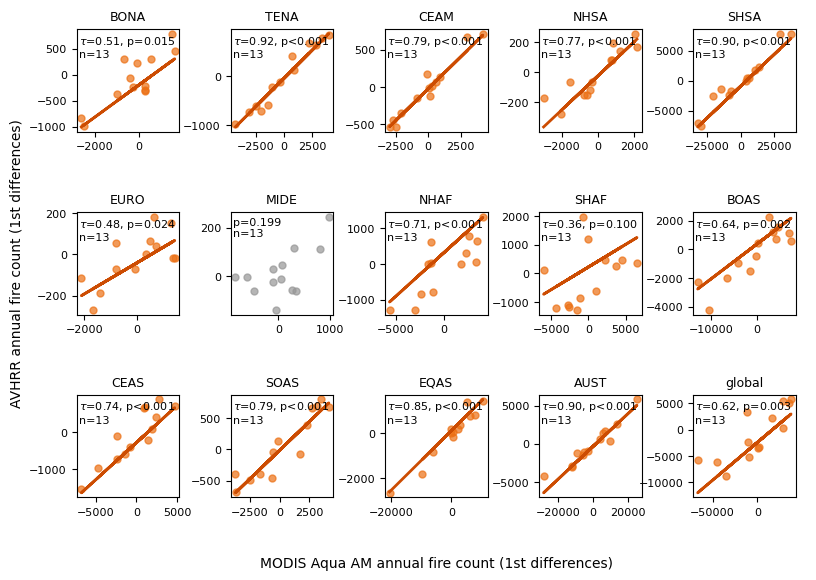

In [17]:
fig, axes, summary = panel_scatter_plot(d=modis3, 
                                        xvar='val_count_1st', 
                                        yvar='count_1st', panelvar='region', 
                                        xlab='MODIS Aqua AM annual fire count (1st differences)', 
                                        ylab='AVHRR annual fire count (1st differences)', 
                                        nrow=3, ncol=5, dim=(210*mm,150*mm),labelcol='region_name') #nrow=3, ncol=5, dim=(12,8)

fig.tight_layout()

fig.savefig(str(dir_out_figures /'s01b_modis_am_intercomparison.png'), dpi=800)
fig.savefig(str(dir_out_figures / 's01b_modis_am_intercomparison.pdf'))
summary.to_csv(str(dir_out_figures / 's01b_modis_am_intercomparison.csv'), index=False)

# COMPARE TO MODIS DAYTIME (AQUA PM)
* Does the AVHRR nighttime data broadly reflect observed MODIS **daytime** patterns over the same time period? (supplemental figure 2)

In [18]:
#load MODIS PM
aquapm_raw = pd.read_csv(str(fn_modis_aqua_pm))
aquapm_raw.rename(columns = {'gfed':'region', 'gfed_name':'region_name'}, inplace = True)
aquapm_raw.head()

,lat,lon180,lon360,dt_utc,dt_lst,hours_lst,date_lst,month,year,doy,region,region_name
0,-25.9918,153.0614,153.0614,2003-01-01 02:50:00,2003-01-01 12:59:31.727067,12.0,2003-01-01,1,2003,1,14,AUST
1,-25.9913,153.0655,153.0655,2003-01-01 02:50:00,2003-01-01 12:59:32.711067,12.0,2003-01-01,1,2003,1,14,AUST
2,-25.9942,153.0196,153.0196,2003-01-01 02:50:00,2003-01-01 12:59:21.695067,12.0,2003-01-01,1,2003,1,14,AUST
3,-25.9949,153.0157,153.0157,2003-01-01 02:50:00,2003-01-01 12:59:20.759067,12.0,2003-01-01,1,2003,1,14,AUST
4,-25.9131,153.0672,153.0672,2003-04-20 03:57:00,2003-04-20 14:10:10.485095,14.0,2003-04-20,4,2003,110,14,AUST


In [19]:
# aggregate to years
aquapm_year = aquapm_raw[['region', 'region_name', 'year', 'doy']]\
    .groupby(['region', 'region_name', 'year'])\
    .agg(['count'])\
    .reset_index()\
    .sort_values('year', ascending=True).droplevel(0, axis=1)

aquapm_year.columns = ['region', 'region_name', 'year', 'val_count']

# combine with annual AVHRR
aquapm_year = aquapm_year.merge(av_gfed, how='inner', on=['region','region_name', 'year'])

## calculate global totals and add to main df
aqua_global = aquapm_year[['year','val_count','count']]\
    .groupby(['year'])[['val_count','count']].sum().reset_index()\
    .sort_values('year', ascending=True)
aqua_global['region'] = 99
aqua_global['region_name'] = 'global'
aqua_global['sat_yr'] = 'dummy'
aqua_global['sat'] = 'dummy'

aquapm_year = pd.concat([aquapm_year, aqua_global])

# calculate first differences
aquapm_year = aquapm_year.groupby(['region','region_name'])\
    .apply(grouped_first_diff, sortCol='year', diffCol='count', outCol='count_1st').reset_index(drop=True)
aquapm_year = aquapm_year.groupby(['region','region_name'])\
    .apply(grouped_first_diff, sortCol='year', diffCol='val_count', outCol='val_count_1st').reset_index(drop=True)

aquapm_year2 = aquapm_year.copy().dropna()

C:\Users\mdejong\AppData\Local\Temp\ipykernel_30360\933313015.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aquapm_year = aquapm_year.groupby(['region','region_name'])\
C:\Users\mdejong\AppData\Local\Temp\ipykernel_30360\933313015.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aquapm_year = aquapm_year.groupby(['region','region_name'])\


### apply some formatting and plot

C:\Users\mdejong\AppData\Local\Temp\ipykernel_30360\3967658821.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


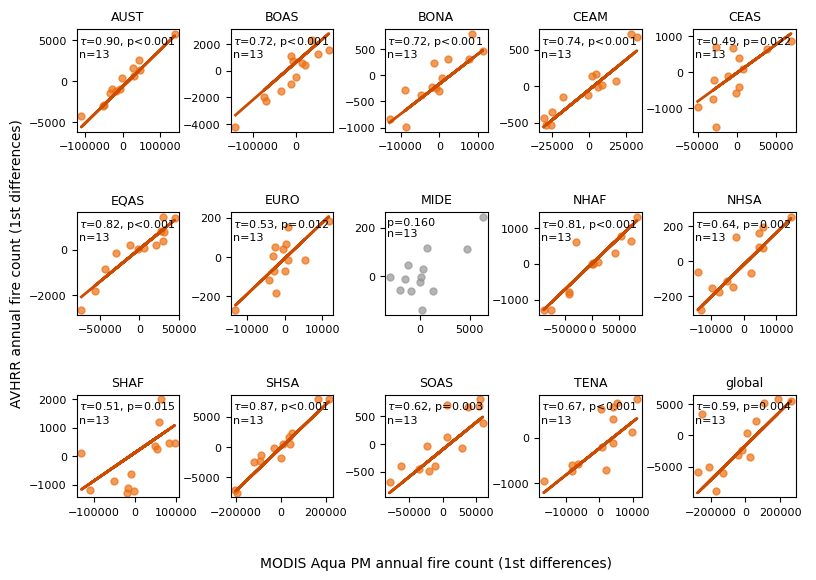

In [20]:
#first diff plot
fig, axes, summary = panel_scatter_plot(d=aquapm_year2, 
                                        xvar='val_count_1st', 
                                        yvar='count_1st', panelvar='region_name', 
                                        xlab='MODIS Aqua PM annual fire count (1st differences)', 
                                        ylab='AVHRR annual fire count (1st differences)', 
                                        nrow=3, ncol=5, dim=(210*mm,150*mm), labelcol='region_name')
fig.tight_layout()
fig.savefig(str(dir_out_figures / 's02_modis_pm_intercomparison.png'), dpi=800)
fig.savefig(str(dir_out_figures / 's02_modis_pm_intercomparison.pdf'))
summary.to_csv(str(dir_out_figures / 's02_modis_pm_intercomparison.csv'), index=False)